In [ ]:
# plan

# - caclulate monthly Q for different land covers 
# - calculate how on average change in lang cover affect the change in runoff -> transport capacity -> TL case 



# plan
# 1 - calculate the monthly water yeild 
# 2 - plot average + spread per month 


In [1]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import os
import seaborn as sns


import functions



In [ ]:
# hydrology does not depend on the sediment input, so in principle hydro.out is the same all the time and only differs per land cover 
# -> its ok to take it from the (chosen) sediment input
# NB: SO FAR (as of 9/12/2024) the landcover 5 has only been run on the TL scenario and is stored in a different place 
# to compare the land covers 
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/langtang_climate_cut/12a/Hydro.out')
testfile


# discharge in m3, but what about other water components?

In [ ]:
def calculate_monthly_water_volume_all(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])
    
    # Check if the specified column exists
    if column not in hydro.columns:
        raise ValueError(f"The specified column '{column}' does not exist in the DataFrame.")
    
    # Scale the specified column by the area
    hydro_scaled = hydro.copy()
    hydro_scaled[column] = hydro_scaled[column] * area
    
    # Set 'D' as the index
    hydro_scaled = hydro_scaled.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro_scaled[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [ ]:
%%time

column = 'PET'  # Set the target column
location = 'langtang'

folder_langtang = '/12a/'
folder_mustang = '/13a/'

folder_location = folder_langtang

landcover1_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover2_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover3_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut'
landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'


output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro'

# Define the list of folder paths
folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut',
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_40percent/{location}_climate_cut', 
                f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_40percent/{location}_climate_cut', 
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut']



# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist()  # Adjust if you need a specific list format


In [ ]:
%%time

# Iterate over folder paths
for folder_path in folder_paths:
    print(f"Processing folder: {folder_path}")

    output_folder = output_path

    # Extract "1landcover" from the folder path
    landcover_part = os.path.basename(os.path.dirname(folder_path))
    landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

    # Load timestep DataFrame (assuming Hydro.out exists in the `/13a/` subfolder for all folders)
    hydro_path = os.path.join(folder_path, '12a', 'Hydro.out')
    print(f"Checking Hydro.out path: {hydro_path}")

    if not os.path.isfile(hydro_path):
        print(f"Hydro.out not found in {hydro_path}")
        continue  # Skip this folder_path if the main Hydro.out is missing

    # Load the Hydro.out file for timestep calculation
    try:
        dfts = pd.read_csv(hydro_path)
        df = calculate_monthly_water_volume_all(dfts, column, area=4830.0)
        df = df[['month', 'year']]
    except Exception as e:
        print(f"Error loading timestep file: {e}")
        continue

    # Initialize the result DataFrame for this folder_path
    result_df = pd.DataFrame()

    # Iterate over subfolders in the folder path
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        
        # Skip files and hidden folders
        if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
            continue

        file_path = os.path.join(subfolder_path, 'Hydro.out')
        print(f"Checking subfolder Hydro.out: {file_path}")

        # Ensure the Hydro.out file exists in the subfolder
        if os.path.isfile(file_path):
            try:
                hydro = pd.read_csv(file_path)
                output_df = calculate_monthly_water_volume_all(hydro, column)

                # Extract and rename the target column
                name_column = output_df[column]
                column_name = f'{column}_{folder_name}'
                result_df[column_name] = name_column
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

    # Ensure result_df has data before proceeding
    if result_df.empty:
        print(f"No valid data found in subfolders of {folder_path}")
        continue

    # Rename columns for clarity and filter by elevation list
    result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
    result_df = result_df[elevation_list]

    # Check for consistency with the elevation list
    if elevation_list == result_df.columns.tolist():
        print("Default land cover. Monthly data: same")

        # Rename columns, merge with timestep, and add folder info
        result_df.columns = elevation.loc['band_data']
        result_df = pd.concat([df, result_df], axis=1)
        result_df['folder'] = os.path.basename(folder_path)

        print(result_df)

        # Define the output file name and save the DataFrame to a CSV file
        output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}.csv'
        print('output filename:', output_filename)
        result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

        print(f"Saved {output_filename}")
    else:
        print(f"The data does not match the elevation list for {folder_path}!")


In [ ]:
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/langtang_climate_cut/12a/Hydro.out')
testfile

In [ ]:
# testfile.snow.plot()

testfile.Pr.plot()
testfile.snowacc.plot()

testfile['snowmelt'] = testfile['snowacc'].where(testfile['snowacc'] < 0).fillna(0)
testfile['snowacc2'] = testfile['snowacc'].where(testfile['snowacc'] > 0).fillna(0)

In [ ]:
testfile.snowacc2.plot()
testfile.snowmelt.plot()

# calculate the monthly values in mm 

In [2]:
def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    if column == 'rainfall':
        hydro['rainfall'] = hydro['Pr'] - hydro['snowacc']
        hydro['rainfall'] = hydro['rainfall'].fillna(0)
        
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').sum().reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [3]:
# test1 = water_balance_components_in_mm(testfile, 'PET')
# test1

In [4]:
%%time

# column = 'Pr'  # Set the target column
location = 'langtang'

folder_langtang = '/12a/'
folder_mustang = '/13a/'


# landcover1_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover2_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/2landcover/{location}_climate_cut'
# landcover3_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut'
# landcover4_folder = f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut' #this one is different - no change in glacier 
# landcover5_folder = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'





output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro'

# Define the list of folder paths
# folder_paths = [f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/1landcover_40percent/{location}_climate_cut',
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/2landcover_40percent/{location}_climate_cut', 
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/3landcover_40percent/{location}_climate_cut', 
#                 f'/Volumes/Extreme SSD/202409_paper2_modelruns/30years/SL_daily/4landcover_40percent/{location}_climate_cut', 
#                 f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut'     ]



folder_paths = [f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/{location}_climate_cut',
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/2landcover/{location}_climate_cut',
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/3landcover/{location}_climate_cut',
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/4landcover/{location}_climate_cut',
                f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/5landcover/{location}_climate_cut']

# folder_paths = [f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/3landcover/{location}_climate_cut']



# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist()  # Adjust if you need a specific list format


CPU times: user 11.7 ms, sys: 4.24 ms, total: 16 ms
Wall time: 13.1 ms


In [5]:
'''%%time

print(column)

# Iterate over folder paths
for folder_path in folder_paths:
    print(f"Processing folder: {folder_path}")

    output_folder = output_path

    # Extract "1landcover" from the folder path
    landcover_part = os.path.basename(os.path.dirname(folder_path))
    landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

    # Load timestep DataFrame (assuming Hydro.out exists in the `/13a/` subfolder for all folders)
    hydro_path = os.path.join(folder_path, '12a', 'Hydro.out')
    print(f"Checking Hydro.out path: {hydro_path}")

    if not os.path.isfile(hydro_path):
        print(f"Hydro.out not found in {hydro_path}")
        continue  # Skip this folder_path if the main Hydro.out is missing

    # Load the Hydro.out file for timestep calculation
    try:
        dfts = pd.read_csv(hydro_path)
        df = water_balance_components_in_mm(dfts, column, area=4830.0)
        df = df[['month', 'year']]
    except Exception as e:
        print(f"Error loading timestep file: {e}")
        continue

    # Initialize the result DataFrame for this folder_path
    result_df = pd.DataFrame()

    # Iterate over subfolders in the folder path
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        
        # Skip files and hidden folders
        if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
            continue

        file_path = os.path.join(subfolder_path, 'Hydro.out')
        # print(f"Checking subfolder Hydro.out: {file_path}")

        # Ensure the Hydro.out file exists in the subfolder
        if os.path.isfile(file_path):
            try:
                hydro = pd.read_csv(file_path)
                output_df = water_balance_components_in_mm(hydro, column)

                # Extract and rename the target column
                name_column = output_df[column]
                column_name = f'{column}_{folder_name}'
                result_df[column_name] = name_column
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

    # Ensure result_df has data before proceeding
    if result_df.empty:
        print(f"No valid data found in subfolders of {folder_path}")
        continue

    # Rename columns for clarity and filter by elevation list
    result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
    result_df = result_df[elevation_list]

    # Check for consistency with the elevation list
    if elevation_list == result_df.columns.tolist():
        print("Default land cover. Monthly data: same")

        # Rename columns, merge with timestep, and add folder info
        result_df.columns = elevation.loc['band_data']
        result_df = pd.concat([df, result_df], axis=1)
        result_df['folder'] = os.path.basename(folder_path)

        print(result_df)

        # Define the output file name and save the DataFrame to a CSV file
        output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
        print('output filename:', output_filename)
        result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

        print(f"Saved {output_filename}")
    else:
        print(f"The data does not match the elevation list for {folder_path}!")
'''

'%%time\n\nprint(column)\n\n# Iterate over folder paths\nfor folder_path in folder_paths:\n    print(f"Processing folder: {folder_path}")\n\n    output_folder = output_path\n\n    # Extract "1landcover" from the folder path\n    landcover_part = os.path.basename(os.path.dirname(folder_path))\n    landcover_base = landcover_part.split(\'_\')[0]  # This gives "1landcover"\n\n    # Load timestep DataFrame (assuming Hydro.out exists in the `/13a/` subfolder for all folders)\n    hydro_path = os.path.join(folder_path, \'12a\', \'Hydro.out\')\n    print(f"Checking Hydro.out path: {hydro_path}")\n\n    if not os.path.isfile(hydro_path):\n        print(f"Hydro.out not found in {hydro_path}")\n        continue  # Skip this folder_path if the main Hydro.out is missing\n\n    # Load the Hydro.out file for timestep calculation\n    try:\n        dfts = pd.read_csv(hydro_path)\n        df = water_balance_components_in_mm(dfts, column, area=4830.0)\n        df = df[[\'month\', \'year\']]\n    except

In [6]:
# loop over columns too 
columns = ['PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']

In [7]:
print(columns)  # Ensure `columns` is defined as a list of column names

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")

    # Iterate over folder paths
    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")

        output_folder = output_path

        # Extract "1landcover" from the folder path
        landcover_part = os.path.basename(os.path.dirname(folder_path))
        landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)
        hydro_path = os.path.join(folder_path, '12a', 'Hydro.out')
        print(f"Checking Hydro.out path: {hydro_path}")

        if not os.path.isfile(hydro_path):
            print(f"Hydro.out not found in {hydro_path}")
            continue  # Skip this folder_path if the main Hydro.out is missing

        # Load the Hydro.out file for timestep calculation
        try:
            dfts = pd.read_csv(hydro_path)
            df = water_balance_components_in_mm(dfts, column, area=4830.0)
            df = df[['month', 'year']]
        except Exception as e:
            print(f"Error loading timestep file: {e}")
            continue

        # Initialize the result DataFrame for this folder_path
        result_df = pd.DataFrame()

        # Iterate over subfolders in the folder path
        for folder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, folder_name)
            
            # Skip files and hidden folders
            if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
                continue

            file_path = os.path.join(subfolder_path, 'Hydro.out')
            # print(f"Checking subfolder Hydro.out: {file_path}")

            # Ensure the Hydro.out file exists in the subfolder
            if os.path.isfile(file_path):
                try:
                    hydro = pd.read_csv(file_path)
                    output_df = water_balance_components_in_mm(hydro, column)

                    # Extract and rename the target column
                    name_column = output_df[column]
                    column_name = f'{column}_{folder_name}'
                    result_df[column_name] = name_column
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

        # Ensure result_df has data before proceeding
        if result_df.empty:
            print(f"No valid data found in subfolders of {folder_path}")
            continue

        # Rename columns for clarity and filter by elevation list
        result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
        result_df = result_df[elevation_list]

        # Check for consistency with the elevation list
        if elevation_list == result_df.columns.tolist():
            print("Default land cover. Monthly data: same")

            # Rename columns, merge with timestep, and add folder info
            result_df.columns = elevation.loc['band_data']
            result_df = pd.concat([df, result_df], axis=1)
            result_df['folder'] = os.path.basename(folder_path)

            print(result_df)

            # Define the output file name and save the DataFrame to a CSV file
            output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
            print('output filename:', output_filename)
            result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

            print(f"Saved {output_filename}")
        else:
            print(f"The data does not match the elevation list for {folder_path}!")


['PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']
Processing column: PET
Processing folder: /Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/langtang_climate_cut
Checking Hydro.out path: /Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/langtang_climate_cut/12a/Hydro.out
Default land cover. Monthly data: same
     month  year       4485.0       3734.0       4880.0       4847.0  \
0        9  1989  1559.052069  1797.691224  1089.386001  1163.894049   
1       10  1989  1412.781155  2048.093003   985.522118   993.866744   
2       11  1989   708.366770  1067.528746   631.722541   638.018209   
3       12  1989   566.089937   702.446187   498.691059   504.179823   
4        1  1990   662.981860   938.517293   590.939732   596.852632   
..     ...   ...          ...          ...          ...          ...   
392      5  2022  1392.583434  2656.194624  1271.326562  1281.451972   
393      6  2022  1260.1

# plots - water balance components 

In [11]:
# plot of interest: 
# barplots with + and - components 
# components:
# AET PET Q GLACIER_MELT SNOW_MELT SNOW_ACC 

# + Pr, snow melt, glacier melt
# - AET PET Q 


def prepare_for_boxplots(df, value_name):
    # value name - column in the output dataframe
    melted = pd.melt(df, id_vars=['month','folder', 'year'], var_name='elevation', value_name=value_name)
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    return melted

In [21]:
# test for landcover 1
landcover_idx = 1

aet1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
snowacc1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


In [22]:
aet1_melted = prepare_for_boxplots(aet1, 'AET')
pet1_melted = prepare_for_boxplots(aet1, 'PET')
Q1_melted = prepare_for_boxplots(Q1, 'Q')

glmelt1_melted = prepare_for_boxplots(glmelt1, 'glmelt')
snowmelt1_melted = prepare_for_boxplots(snowmelt1, 'snowmelt')
pr1_melted = prepare_for_boxplots(pr1, 'Pr')
snowacc1_melted = prepare_for_boxplots(snowacc1, 'snowacc')


# make snowmelt not negative 
snowmelt1_melted['snowmelt'] = snowmelt1_melted['snowmelt'] * -1


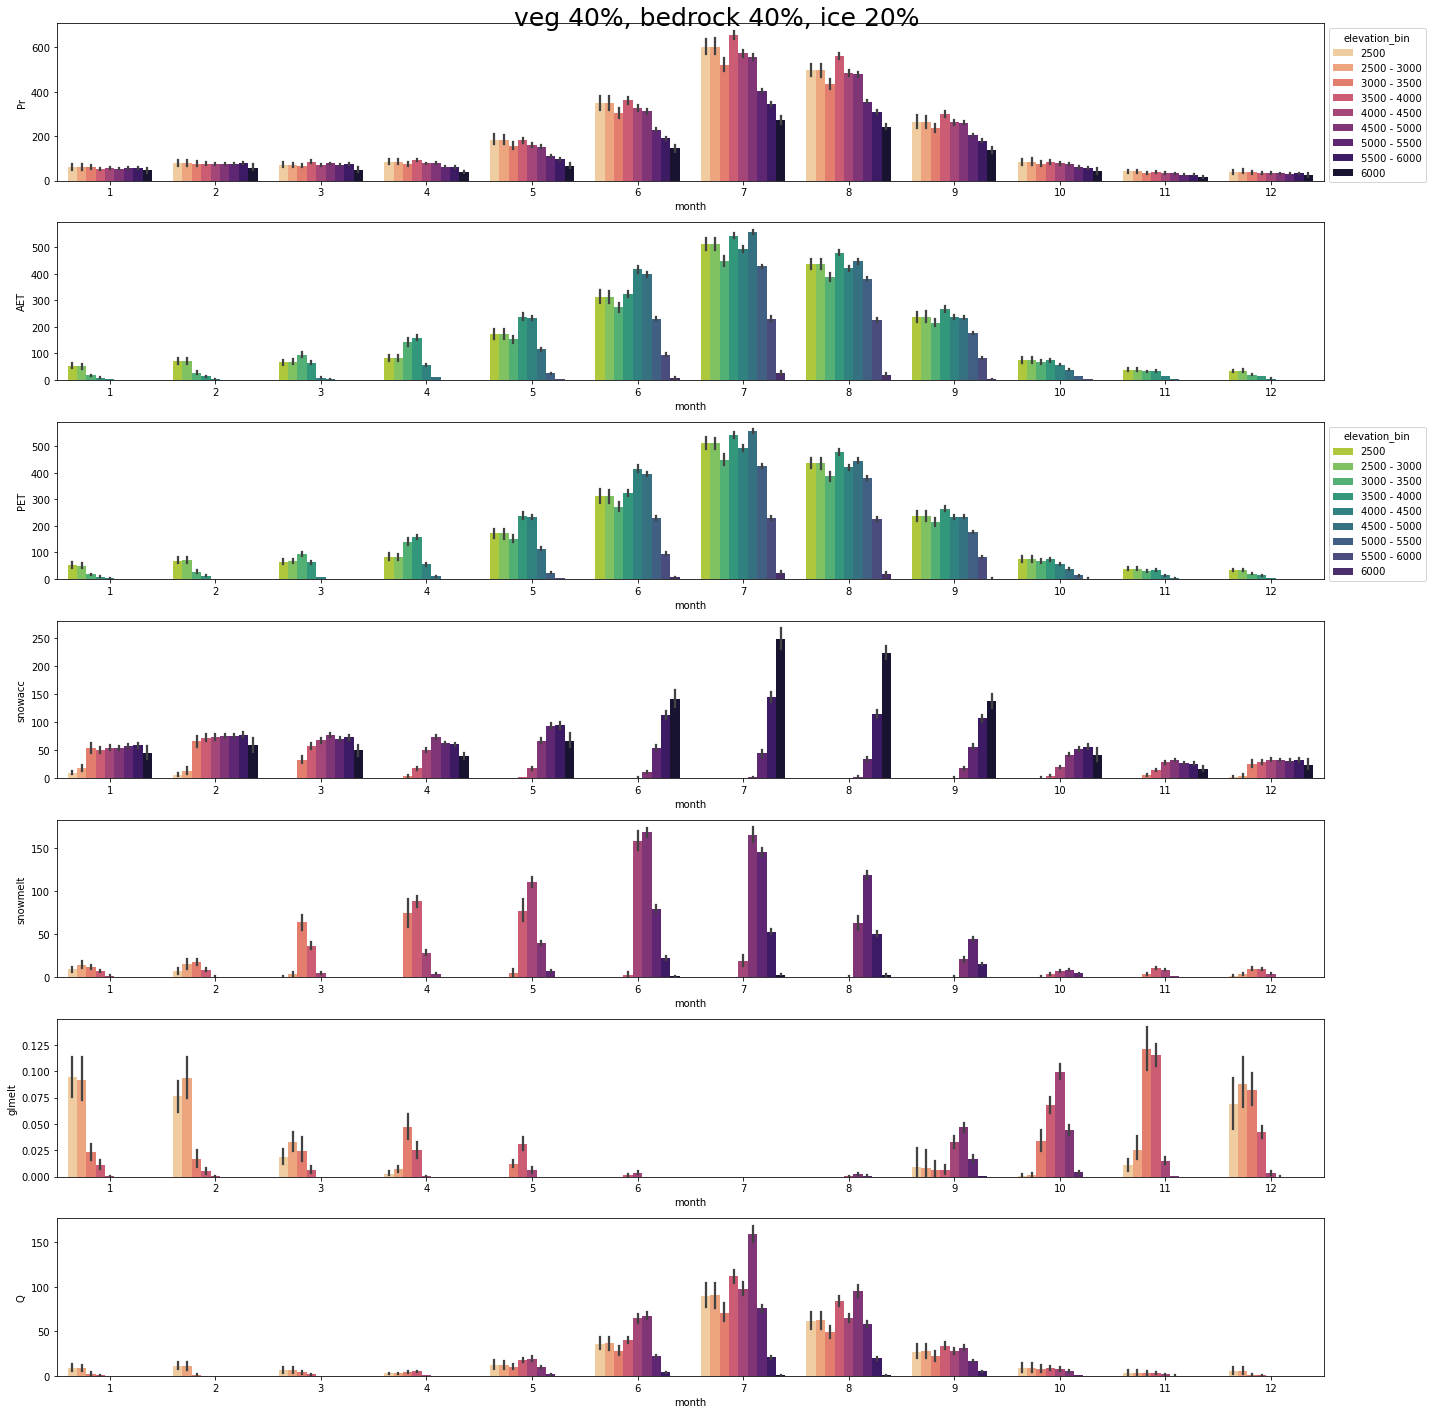

In [24]:
fig = plt.figure(figsize=(20, 20), layout = 'tight')
mosaic = fig.subplot_mosaic('''
                            aaa
                            bbb
                            ccc
                            ddd
                            eee
                            fff
                            ggg
                            ''')


sns.barplot(ax = mosaic['a'], x='month', y='Pr', hue = 'elevation_bin', data=pr1_melted, palette = 'magma_r', legend = True) 
sns.barplot(ax = mosaic['b'], x='month', y='AET', hue = 'elevation_bin', data=aet1_melted, palette = 'viridis_r', legend = False) 
sns.barplot(ax = mosaic['c'], x='month', y='PET', hue = 'elevation_bin', data=pet1_melted, palette = 'viridis_r', legend = True)
sns.barplot(ax = mosaic['d'], x='month', y='snowacc', hue = 'elevation_bin', data=snowacc1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['e'], x='month', y='snowmelt', hue = 'elevation_bin', data=snowmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['f'], x='month', y='glmelt', hue = 'elevation_bin', data=glmelt1_melted, palette = 'magma_r', legend = False)
sns.barplot(ax = mosaic['g'], x='month', y='Q', hue = 'elevation_bin', data=Q1_melted, palette = 'magma_r', legend = False)


sns.move_legend(mosaic['a'], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(mosaic['c'], "upper left", bbox_to_anchor=(1, 1))

# # Adding text to the top-left corner of each subplot
# mosaic['a'].text(0.02, 0.95, 'veg 40%, bedrock 40%, ice 20%', transform=mosaic['a'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['b'].text(0.02, 0.95, 'veg 40%, bedrock 50%, ice 10%', transform=mosaic['b'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['c'].text(0.02, 0.95, 'veg 50%, bedrock 40%, ice 10%', transform=mosaic['c'].transAxes, fontsize=25, verticalalignment='top')
# mosaic['d'].text(0.02, 0.95, 'veg 40%, bedrock 60%, ice 0%',  transform=mosaic['d'].transAxes, fontsize=25, verticalalignment='top')





if landcover_idx ==1:
    plt.suptitle('veg 40%, bedrock 40%, ice 20%', fontsize = 25)
if landcover_idx ==2:
    plt.suptitle('veg 40%, bedrock 50%, ice 10%', fontsize = 25)
if landcover_idx ==3:
    plt.suptitle('veg 50%, bedrock 40%, ice 10%', fontsize = 25)

# plt.savefig('water_balance_components_landcover3.png', dpi = 300, bbox_inches = 'tight')

In [25]:
glmelt1 = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/hydro/langtang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
glmelt1

,month,year,4485.0,3734.0,4880.0,4847.0,3908.0,3756.0,4498.0,4933.0,...,5699.0,5384.0,5217.0,5870.0,5424.0,5763.0,6335.0,5859.0,5936.0,folder
0,9,1989,0.065606,0.167141,0.04078,0.050642,0.151061,0.171611,0.072136,0.046859,...,0.007676,0.068781,0.111760,0.019963,0.050731,0.029003,0.0,0.031991,0.003888,langtang_climate_cut
1,10,1989,0.088684,0.036550,0.00000,0.000000,0.015111,0.035852,0.068903,0.000000,...,0.000000,0.000000,0.003174,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
2,11,1989,0.000000,0.069660,0.00000,0.000000,0.041580,0.091871,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
3,12,1989,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
4,1,1990,0.000000,0.075481,0.00000,0.000000,0.057468,0.108972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,5,2022,0.000000,0.018397,0.00000,0.000000,0.012624,0.056281,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
393,6,2022,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
394,7,2022,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut
395,8,2022,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000495,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,langtang_climate_cut


<AxesSubplot:xlabel='year,month'>

<Figure size 1440x1440 with 0 Axes>

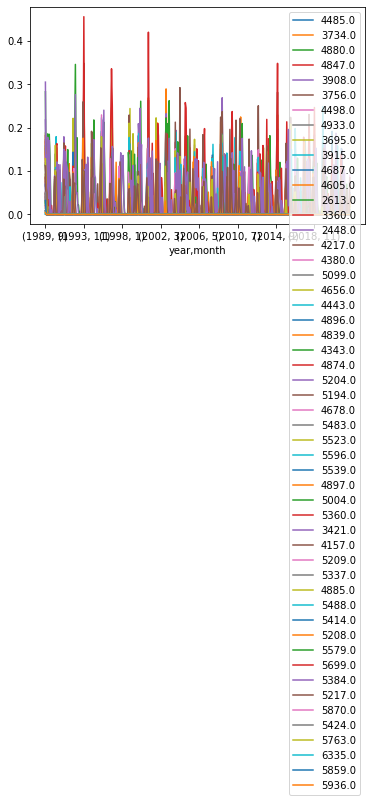

In [27]:
plt.figure(figsize=(20, 20), layout = 'tight')

glmelt1.set_index(['year', 'month']).plot()

In [28]:
testfile = pd.read_csv('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/TL_data/1landcover/langtang_climate_cut/12a/Hydro.out')
testfile

,D,Q,Qs,Qss,Vw,snow,snowacc,PET,AET,Pr,Ta,glacier_melt
0,1989-09-01 00:00:00,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.016218,0.000000,0.009842,3.654126,0.065606
1,1989-09-01 01:00:00,0.004584,0.0,0.004584,0.016501,0.0,0.0,0.000000,0.000000,0.021085,4.217486,0.000000
2,1989-09-01 02:00:00,0.002843,0.0,0.002843,0.033749,0.0,0.0,0.079417,0.012244,0.032336,4.998886,0.000000
3,1989-09-01 03:00:00,0.000003,0.0,0.000003,0.033374,0.0,0.0,0.318469,0.041138,0.040766,6.196086,0.000000
4,1989-09-01 04:00:00,0.000005,0.0,0.000005,0.035781,0.0,0.0,0.668626,0.027107,0.029519,6.960796,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
289987,2022-09-30 19:00:00,0.003515,0.0,0.003515,0.822622,0.0,0.0,3.466897,0.003698,0.003714,1.346846,0.000000
289988,2022-09-30 20:00:00,0.003501,0.0,0.003501,0.819126,0.0,0.0,3.448374,0.001232,0.001237,1.188496,0.000000
289989,2022-09-30 21:00:00,0.003486,0.0,0.003486,0.815641,0.0,0.0,3.419621,0.000000,0.000000,0.942856,0.000000
289990,2022-09-30 22:00:00,0.003471,0.0,0.003471,0.812175,0.0,0.0,3.388863,0.001232,0.001237,0.680256,0.000000


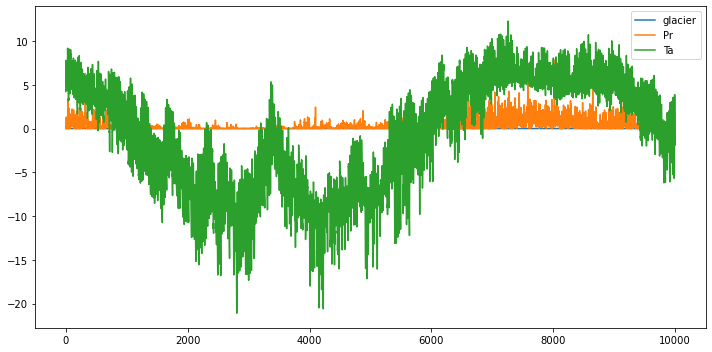

In [34]:
plt.figure(figsize=(10, 5), layout = 'tight')
testfile[1:10000].glacier_melt.plot(label = 'glacier')
testfile[1:10000].Pr.plot(label = 'Pr')
testfile[1:10000].Ta.plot(label = 'Ta')
plt.legend()

<AxesSubplot:>

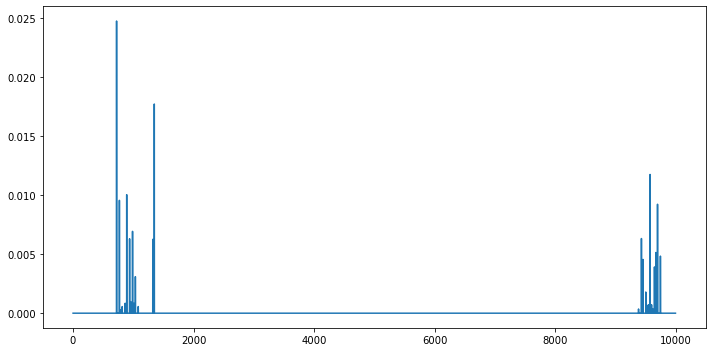

In [38]:
plt.figure(figsize=(10, 5), layout = 'tight')
testfile[1:10000].glacier_melt.plot(label = 'glacier')
# testfile[1:10000].snowacc.plot(label = 'snowacc')